# Sensitivität der Objektdefinition

In diesem Notebook soll untersucht werden, wie sich Änderungen an den Parametern der Objektdefinition auf die sich ergebenden Objekte auswirken. Dazu suchen wir uns einen Falltag und sehen uns zuerst an, wie sich die Parameter auf die Anzahl und die Fläche von Objekten im betrachteten Ausschnitt auswirken.

In [2]:
import numpy as np
import xarray as xr
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from standard_config import *
import sys
sys.path.append("{}/utils/tracking".format(local_home_path))
import object_tracking as ot
import segmentation as oseg

import fixed_colourbar as fc

import glob
import tqdm 

from plotting_tools.colormaps import enhanced_colormap
emap = enhanced_colormap(vmin=210,vmed=240,vmax=300)

import MSGtools as mst

import load_satellite_data as lsd

## 1. Daten laden

Als Falltag nehmen wir den 20.06.2013 und den Zeitpunkt 12:00 UTC, weil es an diesem Tag in diesem Zeitabschnitt viele konvektive Entwicklungen gibt.

In [31]:
# dates = pd.date_range(start="20130620T1200",end="20130620T1300",freq="5min")
d = pd.Timestamp("20130620T1200")

In [32]:
sat_data = {'IR_108':[],'WV_073':[]}

sd = lsd.load_satellite_data_multichannel(d.to_pydatetime(),
                                           ["WV_073","IR_108"],
                                           "eu","rss")
for k in sd.keys():
    sat_data[k].append(sd[k])

Region suggests use of hdf file


Als nächstes variieren wir die Parameter der Objektdefinition.

## 2. Parametervariation

### 2.1 Tiefe der lokalen Minima

Als Ausgangspunkt für die Objektdefinition werden lokale Minima einer bestimmten Tiefe im IR-10,8-µm-Feld benutzt. Wie tief die lokalen Minima sind, hat einen direkten Einfluss darauf, wieviele Objekte gefunden werden können. Das wirkt sich auch auf die Temperatur des lokalen Minimums aus. Deshalb ist dieser Parameter wahrscheinlich einer der wichtigsten für die sich ergebenden Objekte.

In [ ]:
%matplotlib inline

In [40]:
drange = np.arange(1,11)

In [67]:
objects = {d:{} for d in drange}
n_objects = {d:{} for d in drange}
object_area = {d:{} for d in drange}

In [44]:
for d in np.arange(1,11):
    obj = oseg.watershed_local_min_segmentation(sat_data['IR_108'][0],d,273.15,240,5,0)

    objects[d] = obj
    n_objects[d] = np.max(np.unique(obj))

    area = []

    for oid in np.unique(obj)[1:]:
        area.append(len(np.where(obj==oid)[0]))

    object_area[d] = area

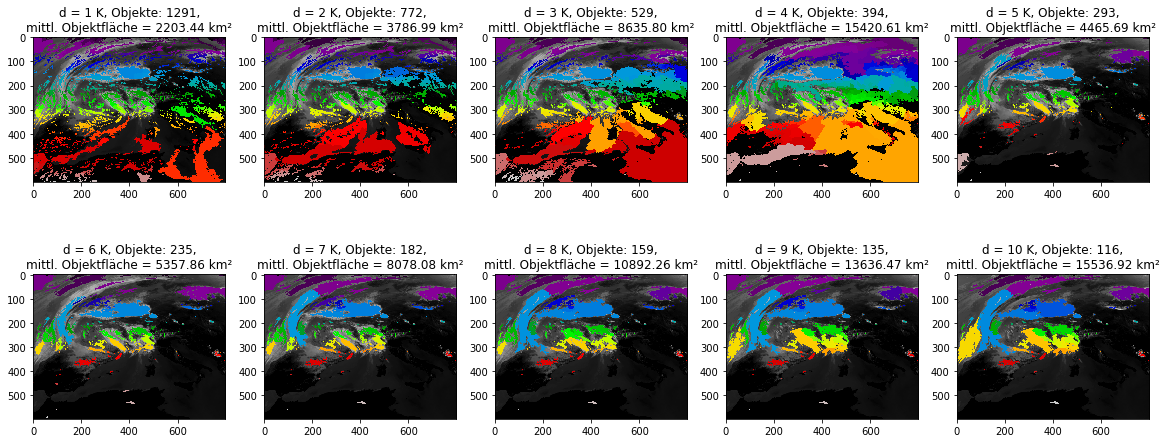

In [48]:
fig,ax = plt.subplots(2,5,figsize=(20,8))
axs  =ax.ravel()

for i,d in enumerate(list(objects.keys())):
    axs[i].imshow(sat_data['IR_108'][0],vmin=210,vmax=300,cmap='gray_r')
    axs[i].imshow(np.ma.masked_less(objects[d],1),vmin=1,vmax=np.max(objects[d]),cmap='nipy_spectral')
    axs[i].set_title(u"d = {} K, Objekte: {},\nmittl. Objektfläche = {:.2f} km²".format(d, n_objects[d],np.mean(object_area[d])*21))

In [56]:
mean_area = []

for d in drange:
    mean_area = [np.mean(object_area[d])*21 for d in object_area.keys()]

Dann sehen wir uns als nächstes die Objektanzahl und die mittlere Objektfläche an.

Text(0, 0.5, 'mittlere Objektfläche / km²')

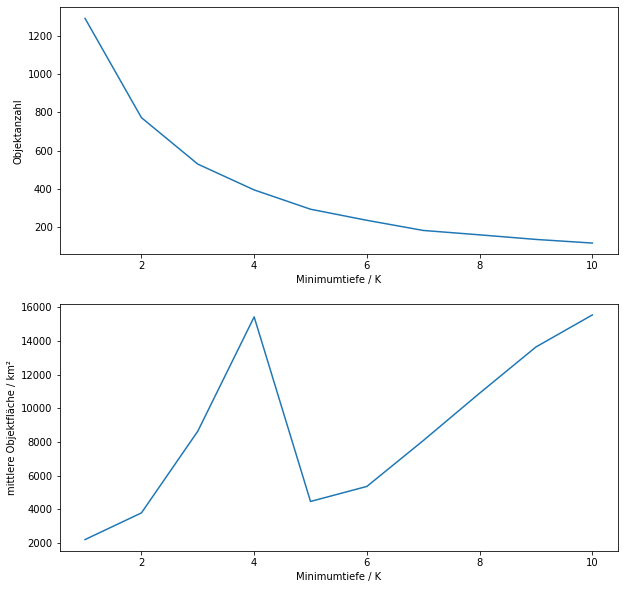

In [59]:
fig,ax = plt.subplots(2,1,figsize=(10,10))
ax[0].plot(list(n_objects.keys()),list(n_objects.values()))
ax[1].plot(list(n_objects.keys()),mean_area)
ax[0].set_xlabel("Minimumtiefe / K")
ax[0].set_ylabel("Objektanzahl")

ax[1].set_xlabel("Minimumtiefe / K")
ax[1].set_ylabel(u"mittlere Objektfläche / km²")

Erwartungsgemäß nimmt zunehmender Objekttiefe die Objektanzahl ab und die Objektfläche zu. Allerdings gibt es bei der mittleren Objektfläche einen Sprung bei einer Tiefe von 3&thinsp;K und 4&thinsp;K, der durch plötzlich auftretende große Objekte hervorgerufen wird. Hier werden lokale Minima ausgewählt bei denen die Berechnung der Objektgrenzen asu dem Ruder läuft. Das kann mehrere Ursachen haben. Zum einen können die Temperaturen der lokalen Minima so hoch sein, dass eine sehr große Fläche als Objekt betrachtet wird. Aber dann sollte dieses Verhalten auch bei geringeren Minimumtiefen auftreten. Eine weitere Ursache ist, dass bei der algorithmischen Zuweisung der Objektfläche etwas schief läuft. Das muss dringend überprüft werden.

In [65]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from skimage.morphology import h_minima

In [78]:
@interact
def plot_object_definitions(#t = (0,288),
                            depth=(0,20),
                            spread=(0,25),
                            t_min=(180,240),
                            t_max=(240,300),
                            t_level=(200,270),
                            s_factor=(0,10)):
    case_object = oseg.watershed_local_min_segmentation(
                    sat_data['IR_108'][0][100:300,400:700],
                    depth=depth,
                    tmin=t_min,
                    tmax=t_max,
                    tlevel=t_level,
                    spread=spread,
                    smoothing_factor=s_factor,
    )
    
    lmins = h_minima(sat_data['IR_108'][0][100:300,400:700],depth)
    
    fig,ax = plt.subplots(1,1,figsize=(10,10))
    ax.imshow(sat_data['IR_108'][0][100:300,400:700],vmin=210,vmax=300,cmap='gray_r')
    ax.contour(case_object,np.unique(case_object)[1:],cmap='Greens') # Objektkonturen
    ax.imshow(np.ma.masked_less(lmins,1),alpha=0.8,cmap='Reds_r') # lokale Minima

interactive(children=(IntSlider(value=10, description='depth', max=20), IntSlider(value=12, description='sprea…